DMI API Tutorial
This tutorial gives an introduction on how to use the Danish Meteorological Institute’s (DMI) API to download meterological observation data (v2).

The tutorial uses the Python programming language and is in the format of a Jupyter Notebook. The notebook can be downloaded and run locally, allowing you to quickly get started downloading data. Part 1 of the tutorial provides some background basic information on how to work with the API, whereas a complete example is provided in Part 2.

If you’re new to the DMI observation data, I recommend that you check out some of the following links:

First, in order to retrieve data, it is necessary to create a user and obtain an API key. This API key grants permission to retrieve data and allows DMI to generate usage statistics.

A guide to creating a user profile and getting an API key can be found here.

In [1]:
api_key = '2a0bf9fc-ab9c-4616-bb48-21ca990be16f' # insert your own key between the '' signs

Part 1: Retrieving data

Part 1 of this tutorial will show how to request data and convert it to a table format. Part 2 will deal with how to request specific data and more advanced data handling.

First, the necessary libraries have to be imported:

In [2]:
import requests # library for making HTTP requests
import pandas as pd # library for data analysis
import datetime as dt # library for handling date and time objects

In the following code block, data is retrieved using the requests.get function. Further information on REST APIs and HTTP request methods can be found here.

In [3]:
DMI_URL = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'
r = requests.get(DMI_URL, params={'api-key': api_key}) # Issues a HTTP GET request
print(r)

<Response [200]>


The response status code indicates whether the request was successful or not. A 200 code means that the retrieval was successful.


Next, we extract the JSON file containing the data from the returned request object. JSON is a human-readable format for data exchange.

In [4]:
json = r.json()  # Extract JSON data
print(json.keys())  # Print the keys of the JSON dictionary

dict_keys(['type', 'features', 'timeStamp', 'numberReturned', 'links'])


When inspecting the json object, it can be noticed that the measurement data is contained within the features:

In [5]:
json['features'][:2]

[{'type': 'Feature',
  'id': 'ab8b22e1-4a9b-1756-5f0d-b0aacb26406a',
  'geometry': {'type': 'Point', 'coordinates': [12.149, 55.3955]},
  'properties': {'parameterId': 'temp_soil',
   'created': '2025-08-23T10:40:52.971453Z',
   'value': 15.6,
   'observed': '2025-08-23T10:40:00Z',
   'stationId': '06174'}},
 {'type': 'Feature',
  'id': 'c26b132d-2337-fcf6-05d0-700b8cbc1785',
  'geometry': {'type': 'Point', 'coordinates': [11.2787, 56.0083]},
  'properties': {'parameterId': 'temp_dry',
   'created': '2025-08-23T10:40:53.063348Z',
   'value': 14.4,
   'observed': '2025-08-23T10:40:00Z',
   'stationId': '06169'}}]

The JSON object can be converted to a convenient table (pandas DataFrame) using pd.json_normalize:

In [6]:
df = pd.json_normalize(json['features'])  # Convert JSON object to a Pandas DataFrame
df.head()  # Print the first five rows of the DataFrame

,type,id,geometry.type,geometry.coordinates,properties.parameterId,properties.created,properties.value,properties.observed,properties.stationId,geometry
0,Feature,ab8b22e1-4a9b-1756-5f0d-b0aacb26406a,Point,"[12.149, 55.3955]",temp_soil,2025-08-23T10:40:52.971453Z,15.6,2025-08-23T10:40:00Z,06174,NaN
1,Feature,c26b132d-2337-fcf6-05d0-700b8cbc1785,Point,"[11.2787, 56.0083]",temp_dry,2025-08-23T10:40:53.063348Z,14.4,2025-08-23T10:40:00Z,06169,NaN
2,Feature,8d60f83a-bb56-a3e1-f880-8fcfa6eaaff1,Point,"[11.2787, 56.0083]",wind_dir,2025-08-23T10:40:53.064293Z,340.0,2025-08-23T10:40:00Z,06169,NaN
3,Feature,6cbf83f5-8a77-0f1e-b02d-a1f9b40bb813,Point,"[11.2787, 56.0083]",wind_max,2025-08-23T10:40:53.06522Z,10.3,2025-08-23T10:40:00Z,06169,NaN
4,Feature,4a3524ee-e5ea-e3db-9dcf-b5565482cebd,Point,"[11.2787, 56.0083]",wind_speed,2025-08-23T10:40:53.065617Z,8.0,2025-08-23T10:40:00Z,06169,NaN


The timestamps strings can be converted to a datetime object using the pandas to_datetime function.

In [7]:
df['time'] = pd.to_datetime(df['properties.observed'])
df['time'].head()  # Print the first five timestamps

0   2025-08-23 10:40:00+00:00
1   2025-08-23 10:40:00+00:00
2   2025-08-23 10:40:00+00:00
3   2025-08-23 10:40:00+00:00
4   2025-08-23 10:40:00+00:00
Name: time, dtype: datetime64[ns, UTC]

Last, we will generate a list of all the available parameters:

In [8]:
parameter_ids = df['properties.parameterId'].unique()  # Generate a list of unique parameter ids
print(parameter_ids)  # Print all unique parameter ids

['temp_soil' 'temp_dry' 'wind_dir' 'wind_max' 'wind_speed' 'visibility'
 'weather' 'humidity' 'visib_mean_last10min' 'sun_last10min_glob'
 'temp_dew' 'precip_dur_past10min' 'wind_min' 'pressure' 'pressure_at_sea'
 'radia_glob' 'cloud_height' 'precip_past10min' 'cloud_cover' 'temp_grass'
 'leav_hum_dur_past10min' 'precip_dur_past1h' 'precip_past1min'
 'wind_speed_past1h']


Part 2: Requesting specific data

The above example was a heavily simplied example to illustrate how the API can be accessed. For most applications you probably want to specify query criterias, such as:

Meterological stations (e.g. 04320, 06074, etc.)
Parameters (e.g. wind_speed, humidity, etc.)
Time frame (to and from time)
Limit (maximum number of observations)
Click the “View to show” button below to see a list of a all stations and parameters.
Due to poor design of the API, it is only possible to request one station or all stations, and similarly, it is only possible to request one parameter or all parameters. To be able to select a subset of stations or parameters it is therefore necessary to loop as shown below. This also avoids hitting the rather low maximum amount of data that can be transferred for each request. The implementation below is most suitable for downloading a few stations and a few parameters, and will incur a significant performance penalty if downloading data for all stations.


In [12]:
# Specify the desired start and end time
start_time = pd.Timestamp(2025, 11, 8)
end_time = pd.Timestamp(2025, 11, 24)

# Specify one or more station IDs or all_stations
stationIds = ['06072']
# Specify one or more parameter IDs or all_parameters
parameterIds = ['radia_glob']

# Derive datetime specifier string
datetime_str = start_time.tz_localize('UTC').isoformat() + '/' + end_time.tz_localize('UTC').isoformat()

dfs = []
for station in stationIds:
    for parameter in parameterIds:
        # Specify query parameters
        params = {
            'api-key' : api_key,
            'datetime' : datetime_str,
            'stationId' : station,
            'parameterId' : parameter,
            'limit' : '300000',  # max limit
        }

        # Submit GET request with url and parameters
        r = requests.get(DMI_URL, params=params)
        # Extract JSON object
        json = r.json() # Extract JSON object
        # Convert JSON object to a MultiIndex DataFrame and add to list
        dfi = pd.json_normalize(json['features'])
        if dfi.empty is False:
            dfi['time'] = pd.to_datetime(dfi['properties.observed'])
            # Drop other columns
            dfi = dfi[['time', 'properties.value', 'properties.stationId', 'properties.parameterId']]
            # Rename columns, e.g., 'properties.stationId' becomes 'stationId'
            dfi.columns = [c.replace('properties.', '') for c in dfi.columns]
            # Drop identical rows (considers both value and time stamp)
            dfi = dfi[~dfi.duplicated()]
            dfi = dfi.set_index(['parameterId', 'stationId', 'time'])
            dfi = dfi['value'].unstack(['stationId','parameterId'])
            dfs.append(dfi)


df = pd.concat(dfs, axis='columns').sort_index()

# Remove the multi-level column index and replace with a tuple index
df.columns = [ (station, parameter) for parameter, station in df.columns ]
df = df.sort_index(axis='columns')

# Rename column 2 from "('radia_glob', '06072')" to "ghi"
df.columns = ['time' if col == 'time' else 'ghi' for col in df.columns]

# Remove the first data point which is erroneous
df = df.iloc[1:]


# Now we need to do quality control of the data using BSRN limit checks
# get the solar zenith angle
import pvlib
import numpy as np
lat, lon = 56.3027, 10.1272  # coordinates of station 06072

# Build DatetimeIndex from the 'time' level and ensure it is timezone-aware in UTC.
times = pd.DatetimeIndex(df.index.get_level_values('time'))
# If times are naive, localize to UTC; if already tz-aware, convert to UTC.
if times.tz is None:
    times = times.tz_localize('UTC')
else:
    times = times.tz_convert('UTC')

solpos = pvlib.solarposition.get_solarposition(times, lat, lon)
zenith = solpos['apparent_zenith']

# BSRN upper limit for global horizontal irradiance
bsrn_ghi_limit = 1.2 * 1366 * np.cos(np.radians(zenith))**1.2 + 50

# BSRN lower limit for global horizontal irradiance
bsrn_ghi_limit_lower = -2

# add zenith and bsrn_ghi_limit to dataframe
df['zenith'] = zenith.values
df['bsrn_ghi_limit'] = bsrn_ghi_limit.values

# Apply BSRN limit check: set ghi to NaN where it exceeds the limit
df.loc[df['ghi'] > df['bsrn_ghi_limit'], 'ghi'] = np.nan
df.loc[df['ghi'] < bsrn_ghi_limit_lower, 'ghi'] = np.nan

df.to_csv('station_data.csv')


# Resample data to hourly values by taking the mean of each hour with right edge labels and closed intervals
df_resampled = df.resample('H', closed='right', label='right').mean()

# drop zenith and bsrn_ghi_limit columns
df_resampled = df_resampled.drop(columns=['zenith', 'bsrn_ghi_limit'])

# Save resampled data to CSV file
df_resampled.to_csv('station_data_hourly.csv')





/var/folders/ms/tf6jblk57zqfkczt3wf8pj740000gn/T/ipykernel_41727/3440353660.py:92: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('H', closed='right', label='right').mean()


If the request was succesfull, the dataframe df now contains the requested data. The dataframe is a MultiIndex dataframe and has two column levels (station and parameter). The index is the observation time.

MultiIndex dataframes are extremely convenient and versatile, though they do take some time getting used to. As an example, the below command demonstrates how to get the wind speed from the station 04250 for four days in December:

In [10]:
df.loc['2025-11-08':, ('06072', 'radia_glob')]

KeyError: "None of [Index(['06072', 'radia_glob'], dtype='object')] are in the [columns]"

The last step is to visualize the data. As an example, we’ll visualize the wind speed and global horizontal irradiance (GHI) for the station 04250.

Text(0, 0.5, 'Global horizontal\nirradiance [W/m$^2$]')

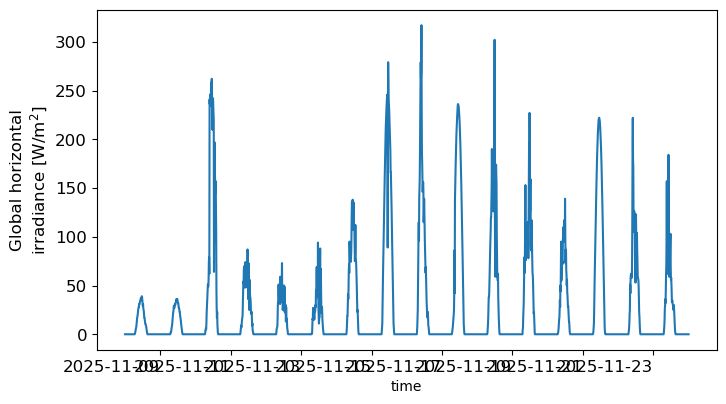

In [ ]:
station = '06072'  # station to plot
params = ['radia_glob']  # parameters to plot

# Generate plot of data
ax = df[station][params].plot(figsize=(8,5), legend=False, fontsize=12, rot=0, subplots=True)
ax[0].set_ylabel('Global horizontal\nirradiance [W/m$^2$]', size=12)